In [1]:
import numpy as np
from numpy.fft import rfft,irfft
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
realdata=np.fromfile("../../data/100ms.bin",'u2')

In [54]:
N=len(realdata)
mean=realdata.mean()
rms=np.sqrt(realdata.var())
fakedata=np.rint(np.random.normal(mean,rms,N))
# see http://stackoverflow.com/questions/4389517/in-place-type-conversion-of-a-numpy-array
fakedata=fakedata.astype('u2')
Ns=4096
Na=65917
print len(fakedata),Na*Ns
dt=1.0/2.5e9 #2.5 GSample/s

269996032 269996032


In [30]:
print realdata.mean(), fakedata.mean()
print realdata.var(), fakedata.var()
print realdata.min(), fakedata.min()
print realdata.max(), fakedata.max()
mn=realdata.min()
mx=realdata.max()

2043.23839954 2043.23848049
5.3710694829 5.45461532297
2028 2030
2062 2056


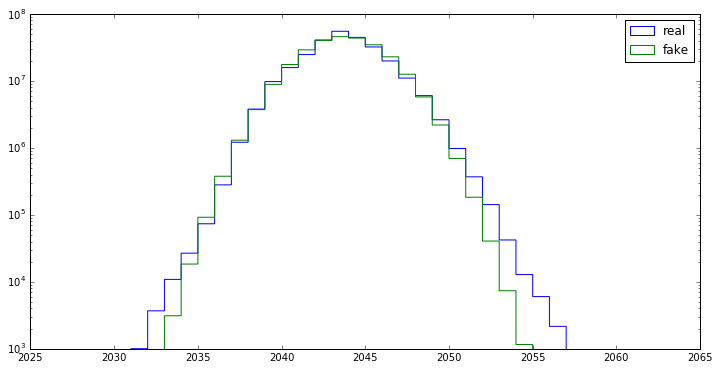

In [38]:
## first plot, simple histograms, but we want to do it in integer values
figure(figsize=(12,6))
hist(realdata,bins=mx-mn,range=[mn,mx],histtype='step',label='real')
hist(fakedata,bins=mx-mn,range=[mn,mx],histtype='step',label='fake')
semilogy()
legend()

In [41]:
## let's see other moments
for i in range(1,5):
    print i,((realdata-mean)**i).mean(), ((fakedata-mean)**i).mean()

 1 2.15449121899e-14 8.09493378251e-05
2 5.3710694829 5.45461532953
3 1.23100010735 -0.00356835382365
4 98.2404956191 89.2490167281


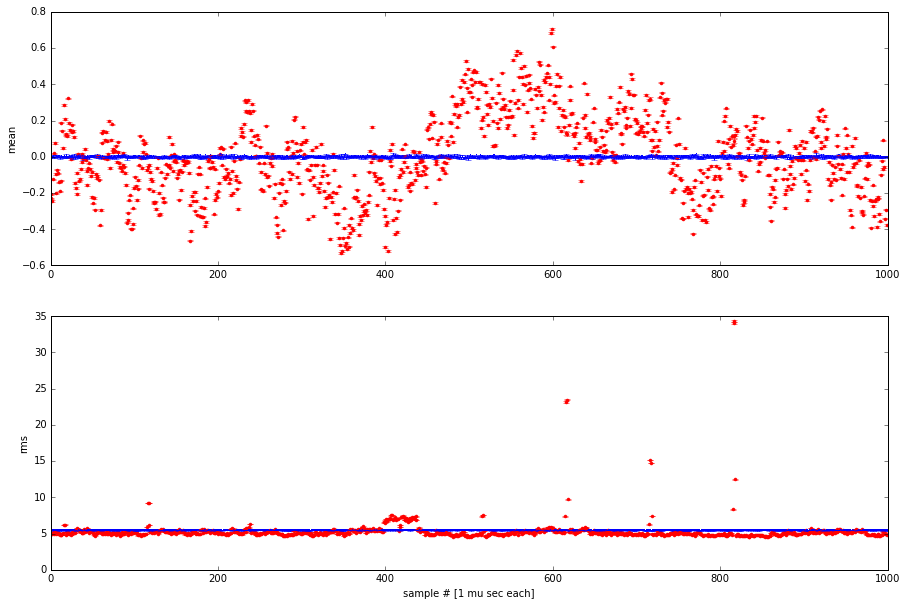

In [127]:
## see constancy in time in both mean and power
Ns=1000
S=N/Ns
figure(figsize=(15,10))
for i in range(Ns):
    for da,fmt in [(realdata,'r.'),(fakedata,'b,')]:
        dac=da[i*S:(i+1)*S]
        mn=dac.mean()-mean
        mne=sqrt(dac.var())/sqrt(S)
        pow=dac.var()
        powe=2*dac.var()/sqrt(S)
        subplot(2,1,1)
        errorbar(i,mn,yerr=mne,fmt=fmt)
        subplot(2,1,2)
        errorbar(i,pow,yerr=powe,fmt=fmt)
        #print i,mn,mne
subplot(2,1,2)
pylab.xlabel('sample # [1 mu sec each]')
pylab.ylabel('rms')
subplot(2,1,1)
pylab.ylabel('mean')

        

In [52]:
def polyphase(sam,Na, Nx,dt):
    Nt=Na*Nx
    assert(len(sam)==Nt)
    rang=arange(Nt)
    filt=numpy.sinc((rang-Nt/2)/(1.0*Nx))
    filt*=0.5*(1-cos(rang*2*np.pi/Nt))
    filt*=sam
    for j in range(Na):
        if j==0:
            pp=filt[0:Nx]
        else:
            pp+=filt[j*Nx:(j+1)*Nx]
    pow=rfft(pp)
    pow=abs(pow*pow)
    tmax=Nx*dt
    freq=arange(len(pow))/tmax/1e6
    return freq,pow

In [65]:
freq,powr=polyphase(realdata,Na/29,Ns*29,dt)
freq,powf=polyphase(fakedata,Na/29,Ns*29,dt)

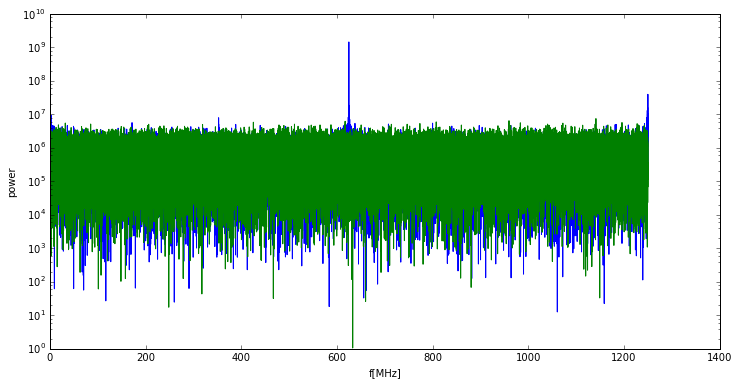

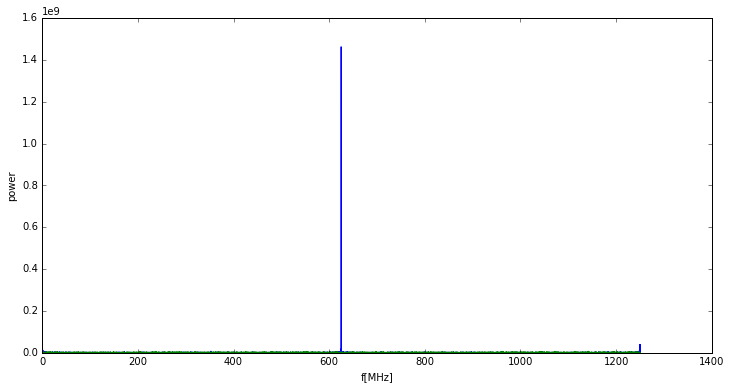

In [128]:
#throw away first bin, as this is the DC power
figure(figsize=(12,6))
plot(freq[1:],powr[1:])
plot(freq[1:],powf[1:])
pylab.xlabel("f[MHz]")
pylab.ylabel("power")

semilogy()
figure(figsize=(12,6))
plot(freq[1:],powr[1:])
plot(freq[1:],powf[1:])
pylab.xlabel("f[MHz]")
pylab.ylabel("power")


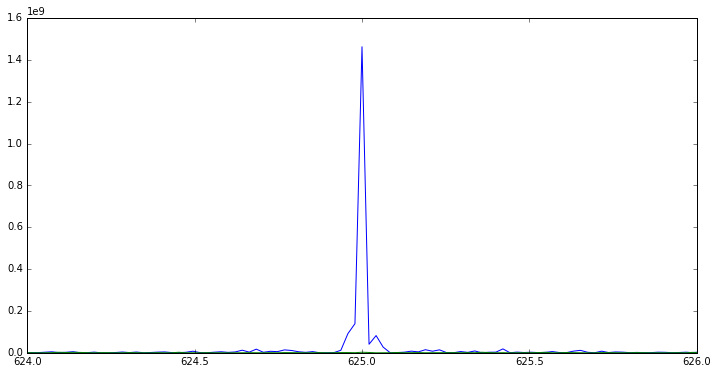

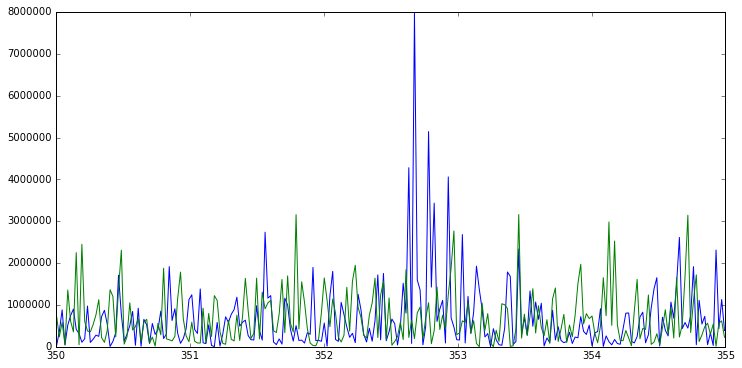

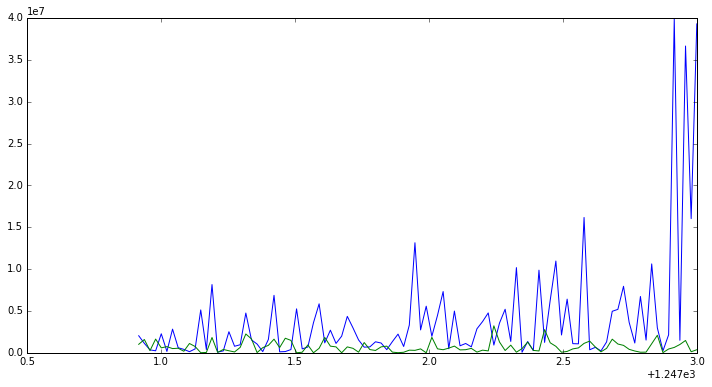

In [86]:
#zoom into the region
figure(figsize=(12,6))
plot(freq[1:],powr[1:])
plot(freq[1:],powf[1:])
xlim(624,626)

figure(figsize=(12,6))
c=np.where((freq<355)&(freq>350))
plot(freq[c],powr[c])
plot(freq[c],powf[c])

figure(figsize=(12,6))
plot(freq[-100:],powr[-100:])
plot(freq[-100:],powf[-100:])


In [118]:
## now, let's see the very low end power.
def lowpower(sam,Nbins,Navg,dt):
    Nt=len(sam)
    tmax=Nt*dt
    freq=(0.5+1/(2*Navg)+arange(Nbins))*Navg/tmax
    fd=rfft(sam)[1:Nbins*Navg+1]
    ## now average
    toret=[]
    for i in range(Nbins):
        toret.append((abs(fd[i*Navg:(i+1)*Navg])**2).sum())
    return freq,np.array(toret)

In [124]:
lowf,lowpr=lowpower(realdata,4000,16,dt)
lowf,lowpf=lowpower(fakedata,4000,16,dt)

[]

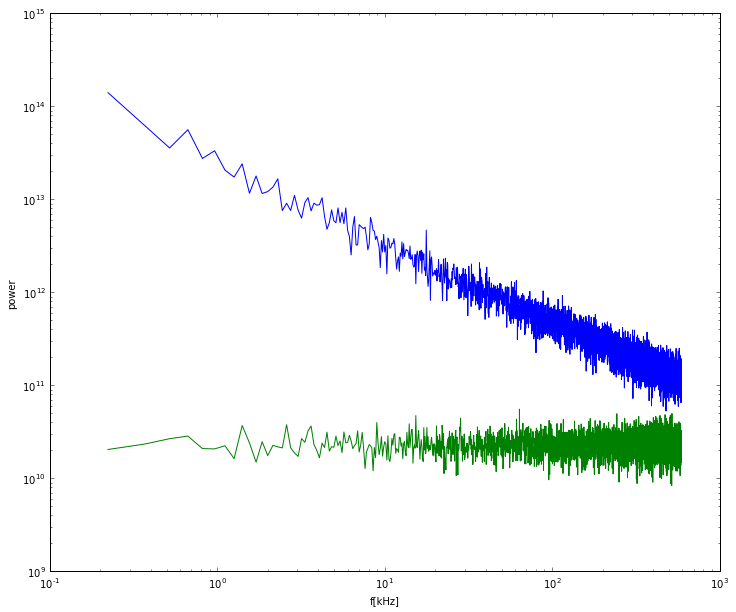

In [126]:
figure(figsize=(12,10))
plot(lowf[1:]/1000,lowpr[1:])
plot(lowf[1:]/1000,lowpf[1:])
pylab.xlabel("f[kHz]")
pylab.ylabel("power")
loglog()